In [2]:
import os 
import sys
sys.path.insert(0, os.path.join(os.path.dirname("test_pipeline.ipynb"), '..'))

from omegaconf import OmegaConf
from hydra import compose, initialize

import matplotlib.pyplot as plt

import torch

from src.datasets.biomass_dataset import prepare_train_df
from src.models.two_stream import build_model, get_stream_mode
from src.trainer.lightning_datamodule import BiomassDataModule

/home/ib/CSIRO-Image2BiomassPrediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cfg = OmegaConf.load("../configs/config.yaml")

with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="config")

In [4]:
train_df = prepare_train_df(cfg.data.train_csv)

In [5]:
train_df

target_name,image_path,Sampling_Date,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,2015/9/4,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,2015/4/1,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,2015/9/1,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,2015/5/18,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,2015/9/11,0.4343,23.2239,10.5261,34.1844,10.9605
...,...,...,...,...,...,...,...
352,train/ID975115267.jpg,2015/7/8,40.0300,0.0000,0.8000,40.8300,40.8300
353,train/ID978026131.jpg,2015/9/4,24.6445,4.1948,12.0601,40.8994,36.7046
354,train/ID980538882.jpg,2015/2/24,0.0000,1.1457,91.6543,92.8000,91.6543
355,train/ID980878870.jpg,2015/7/8,32.3575,0.0000,2.0325,34.3900,34.3900


# Test Datamodule

In [5]:
image_dir = cfg.data.train_image_dir
stream_mode = get_stream_mode(cfg.model.model_type)
img_size = cfg.data.img_size
batch_size = cfg.training.batch_size
num_workers = cfg.training.num_workers
n_folds = cfg.data.n_folds
fold = 1

data_module = BiomassDataModule(
    train_df=train_df,
    image_dir=image_dir,
    stream_mode=stream_mode, # two_stream by default
    img_size=img_size,
    batch_size=batch_size,
    num_workers=num_workers,
    n_folds=n_folds,
    fold_idx=fold - 1,  # Convert to 0-indexed
)
data_module.setup()


data_module_single_stream = BiomassDataModule(
    train_df=train_df,
    image_dir=image_dir,
    stream_mode="single_stream",
    img_size=img_size,
    batch_size=batch_size,
    num_workers=num_workers,
    n_folds=n_folds,
    fold_idx=fold - 1,  # Convert to 0-indexed
)
data_module_single_stream.setup()


## Test two stream

In [6]:
train_loader = data_module.train_dataloader()
train_loader

In [7]:
train_loader_iter = iter(train_loader)
batch = next(train_loader_iter)
batch


[tensor([[[[ 1.4440,  1.3927,  1.3070,  ...,  0.8104,  1.0331,  1.3413],
           [ 1.3242,  1.3755,  1.3070,  ...,  0.3481,  0.4337,  1.5297],
           [ 0.8276,  1.3070,  1.3584,  ..., -0.5424,  0.0569,  1.7865],
           ...,
           [-1.2445, -1.2959, -1.5870,  ..., -0.4911, -0.1999, -0.1314],
           [-1.7412, -1.8439, -1.8782,  ...,  0.4166,  0.1768,  0.1939],
           [-1.7412, -1.7583, -1.6898,  ...,  1.8550,  1.2557,  0.7248]],
 
          [[ 1.9559,  1.8683,  1.7808,  ...,  0.8354,  1.0455,  1.3431],
           [ 1.8333,  1.9034,  1.8508,  ...,  0.3803,  0.4153,  1.5182],
           [ 1.3081,  1.8333,  1.9034,  ..., -0.5476,  0.0301,  1.7633],
           ...,
           [-0.6702, -0.7577, -1.1078,  ..., -0.1450,  0.1527,  0.2577],
           [-1.1604, -1.3004, -1.3529,  ...,  0.8529,  0.6429,  0.6604],
           [-1.1429, -1.1779, -1.1779,  ...,  2.4111,  1.8859,  1.3256]],
 
          [[ 0.7751,  0.7228,  0.7054,  ...,  0.2348,  0.5311,  0.8971],
           [ 

In [8]:
batch[0].shape

torch.Size([8, 3, 768, 768])

In [9]:
batch[1].shape

torch.Size([8, 3, 768, 768])

In [10]:
batch[2].shape

torch.Size([8, 3])

In [11]:
def show_rgb_tensor(img, title=None):
    """
    Plots an RGB image from a tensor or numpy array.
    
    Supports:
    - PyTorch tensor with shape (3, H, W)
    - Tensor with shape (H, W, 3)
    - NumPy versions of the same

    Automatically moves to CPU and converts to numpy.
    """
    # Convert to CPU numpy
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    
    # If CHW -> HWC
    if img.shape[0] == 3 and img.ndim == 3:
        img = img.transpose(1, 2, 0)
    
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


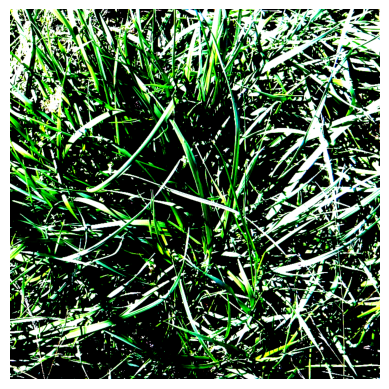

In [12]:
show_rgb_tensor(batch[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6225708].


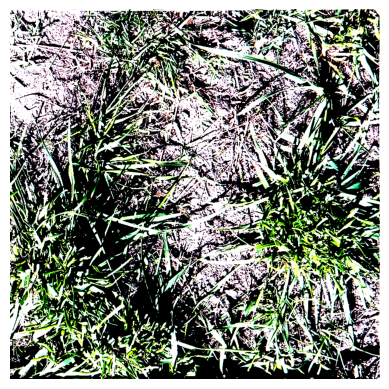

In [13]:
show_rgb_tensor(batch[0][1])

In [14]:
batch[2][0]

tensor([81., 81., 81.])

## Test single stream

In [15]:
train_loader_single_stream = data_module_single_stream.train_dataloader()
train_loader_single_stream_iter = iter(train_loader_single_stream)
batch_single_stream = next(train_loader_single_stream_iter)
batch_single_stream


[tensor([[[[ 1.2899,  1.1700,  0.9303,  ...,  1.2728,  1.4098,  1.4440],
           [ 1.2214,  1.0159,  0.5707,  ...,  1.1872,  1.3755,  1.3755],
           [ 1.1529,  0.8961,  0.3994,  ...,  1.0673,  1.3070,  1.1872],
           ...,
           [ 1.1358,  1.2043,  1.4269,  ...,  1.2728,  0.2796,  0.0398],
           [ 1.4612,  1.8722,  1.9920,  ...,  1.2728,  0.8961,  0.0398],
           [ 2.0777,  2.2318,  2.2318,  ...,  1.3584,  1.2385,  0.3309]],
 
          [[ 1.3782,  1.3606,  1.2906,  ...,  1.3957,  1.5357,  1.6057],
           [ 1.3081,  1.2206,  0.9230,  ...,  1.3256,  1.5007,  1.5182],
           [ 1.2206,  1.0980,  0.7479,  ...,  1.2031,  1.4307,  1.3081],
           ...,
           [ 1.1681,  1.2731,  1.5007,  ...,  1.3431,  0.2927,  0.0126],
           [ 1.4832,  1.9384,  2.0609,  ...,  1.2906,  0.9055,  0.0301],
           [ 2.1310,  2.3235,  2.3410,  ...,  1.3606,  1.2381,  0.3627]],
 
          [[ 0.9319,  0.7576,  0.4439,  ...,  1.2108,  1.3502,  1.4025],
           [ 

In [16]:
len(batch_single_stream)

2

In [17]:
batch_single_stream[0].shape

torch.Size([8, 3, 768, 768])

In [18]:
batch_single_stream[1].shape

torch.Size([8, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6225708].


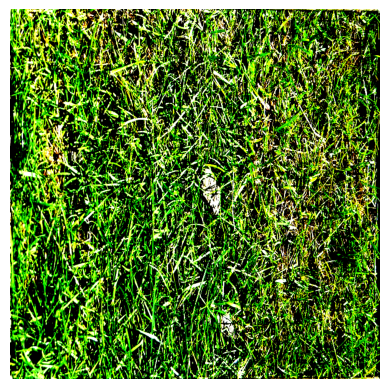

In [19]:
show_rgb_tensor(batch_single_stream[0][0]) # rescaling of single image to 768x768 looks weird :)

In [20]:
# data_module_single_stream = BiomassDataModule(
#     train_df=train_df,
#     image_dir=image_dir,
#     stream_mode="single_stream",
#     img_size=1024,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     n_folds=n_folds,
#     fold_idx=fold - 1,  # Convert to 0-indexed
#     use_augmentation=False,
# )
# data_module_single_stream.setup()

# train_loader_single_stream = data_module_single_stream.train_dataloader()
# train_loader_single_stream_iter = iter(train_loader_single_stream)
# batch_single_stream = next(train_loader_single_stream_iter)

In [21]:
# show_rgb_tensor(batch_single_stream[0][1]) # 1024x1024 still weird

# Test Model

## Two Stream

In [22]:
cfg.model

{'model_type': 'two_stream', 'backbone': {'name': 'convnext_tiny', 'pretrained': True}, 'heads': {'dropout': 0.3, 'hidden_ratio': 0.25}, 'tiled': {'grid': [2, 2]}, 'save_path': '${checkpoint_dir}'}

In [23]:
def model_fn():
    grid = tuple(cfg.model.tiled.grid) if "tiled" in cfg.model.model_type else None
    return build_model(
        model_type=cfg.model.model_type,
        backbone_name=cfg.model.backbone.name,
        pretrained=cfg.model.backbone.pretrained,
        dropout=cfg.model.heads.dropout,
        hidden_ratio=cfg.model.heads.hidden_ratio,
        grid=grid,
    )
model = model_fn()
model

TwoStreamMultiHead(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_

In [24]:
backbone = model.backbone

In [25]:
batch[0][0].shape, batch[0][1].shape

(torch.Size([3, 768, 768]), torch.Size([3, 768, 768]))

In [26]:
batch_single_stream[0][0].shape

torch.Size([3, 768, 768])

In [27]:
backbone

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [34]:
backbone_output_left = backbone(batch[0][0].unsqueeze(0))
backbone_output_right = backbone(batch[0][1].unsqueeze(0))
backbone_output_left.shape, backbone_output_right.shape

(torch.Size([1, 768]), torch.Size([1, 768]))

In [35]:
model.softplus

Softplus(beta=1.0, threshold=20.0)

In [36]:
backbone_output = torch.cat([backbone_output_left, backbone_output_right], dim=1)
backbone_output.shape

torch.Size([1, 1536])

In [37]:
model.softplus(backbone_output)

tensor([[1.3074, 1.0188, 0.2560,  ..., 0.6430, 1.0924, 0.6755]],
       grad_fn=<SoftplusBackward0>)

In [38]:
model_head_total = model.head_total
model_head_total

Sequential(
  (0): Linear(in_features=1536, out_features=384, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=384, out_features=1, bias=True)
)

In [39]:
backbone_output

tensor([[ 0.9920,  0.5709, -1.2318,  ..., -0.1030,  0.6839, -0.0356]],
       grad_fn=<CatBackward0>)

In [40]:
model_head_total(backbone_output)

tensor([[0.0389]], grad_fn=<AddmmBackward0>)

## Single Stream

In [41]:
def model_fn():
    grid = tuple(cfg.model.tiled.grid) if "tiled" in cfg.model.model_type else None
    return build_model(
        model_type="single_stream",
        backbone_name=cfg.model.backbone.name,
        pretrained=cfg.model.backbone.pretrained,
        dropout=cfg.model.heads.dropout,
        hidden_ratio=cfg.model.heads.hidden_ratio,
        grid=grid,
    )
model = model_fn()
model

SingleStreamMultiHead(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (co

In [42]:
batch_single_stream[0][0].shape

torch.Size([3, 768, 768])

In [43]:
backbone_output_single_stream = backbone(batch_single_stream[0][0].unsqueeze(0))
backbone_output_single_stream.shape

torch.Size([1, 768])

In [45]:
head_gdm = model.head_gdm
head_gdm

Sequential(
  (0): Linear(in_features=768, out_features=192, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=192, out_features=1, bias=True)
)

In [46]:
head_gdm(backbone_output_single_stream)

tensor([[0.3686]], grad_fn=<AddmmBackward0>)

# Test Backbones

In [ ]:
import timm
import torch.nn as nn

print(timm.__version__)

backbone_name = "convnext_tiny"
backbone = timm.create_model(backbone_name, pretrained=True)
backbone

1.0.22


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [ ]:
model = timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=True)
model


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=Fal

# Test Inference

In [6]:
def model_fn():
    grid = tuple(cfg.model.tiled.grid) if "tiled" in cfg.model.model_type else None
    return build_model(
        model_type=cfg.model.model_type,
        backbone_name=cfg.model.backbone.name,
        pretrained=False,  # We load from checkpoint
        dropout=cfg.model.heads.dropout,
        hidden_ratio=cfg.model.heads.hidden_ratio,
        grid=grid,
    )

In [7]:
# model_1 = torch.load(os.path.join(os.path.dirname("test_pipeline.ipynb"), '..', cfg.inference.checkpoint_dir, "best_model_fold1.ckpt"))
# model_1.keys()

In [8]:
from src.inference.predictor import Predictor, load_fold_models

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n[1/4] Loading {cfg.inference.n_folds} fold models...")
models = load_fold_models(
    model_fn=model_fn,
    checkpoint_dir=os.path.join(os.path.dirname("test_pipeline.ipynb"), '..', "checkpointsOld/prekol"),
    # n_folds=cfg.inference.n_folds,
    device=device,
)


[1/4] Loading 5 fold models...
Found 5 checkpoints
→ Loading: best_model_fold1-v2.ckpt
→ Loading: best_model_fold2-v2.ckpt
→ Loading: best_model_fold3-v2.ckpt
→ Loading: best_model_fold4-v2.ckpt
→ Loading: best_model_fold5-v2.ckpt
✓ Loaded 5 models successfully


In [9]:
stream_mode = get_stream_mode(cfg.model.model_type)

In [10]:
predictor = Predictor(
    models=models,
    stream_mode=stream_mode,
    device=device,
    use_amp=cfg.inference.use_amp,
    use_tta=cfg.inference.use_tta,
)

In [11]:
import pandas as pd

test_long_df = pd.read_csv(cfg.data.test_csv)
test_unique_df = test_long_df.drop_duplicates(subset=["image_path"]).reset_index(drop=True)
print(f"✓ Found {len(test_unique_df)} unique test images")

✓ Found 1 unique test images


In [12]:
test_unique_df

,sample_id,image_path,target_name
0,ID1001187975__Dry_Clover_g,test/ID1001187975.jpg,Dry_Clover_g


In [13]:
predictions = predictor.predict_with_tta(
    test_df=test_unique_df,
    image_dir=cfg.data.test_image_dir,
    img_size=cfg.data.img_size,
    batch_size=cfg.inference.batch_size,
    num_workers=cfg.inference.num_workers,
)

TTA View 1/3


Predicting:   0%|          | 0/1 [00:00<?, ?it/s]/home/ib/CSIRO-Image2BiomassPrediction/notebooks/../src/inference/predictor.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


TTA View 2/3


Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


TTA View 3/3


Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


In [14]:
predictions

array([[24.470835 , 11.068749 ,  2.2458334, 26.552084 , 37.620834 ]],
      dtype=float32)

In [15]:
from scripts.inference import main as inference_main

In [16]:
cfg.inference.checkpoint_dir

'checkpoints/two_stream_timm/vit_base_patch14_dinov2.lvd142m_fixed_glob_r2'

In [17]:
import os 

cfg.inference.checkpoint_dir = os.path.join(os.path.dirname("test_pipeline.ipynb"), '..', "checkpointsOld/prekol")
cfg.inference.checkpoint_dir

'../checkpointsOld/prekol'

In [18]:
inference_main(cfg)

CSIRO Biomass Prediction - Inference

Device: cuda
Model type: two_stream
Stream mode: two_stream

[1/4] Loading 5 fold models...
Found 5 checkpoints
→ Loading: best_model_fold1-v2.ckpt
→ Loading: best_model_fold2-v2.ckpt
→ Loading: best_model_fold3-v2.ckpt
→ Loading: best_model_fold4-v2.ckpt
→ Loading: best_model_fold5-v2.ckpt
✓ Loaded 5 models successfully

[2/4] Loading test data...
✓ Found 1 unique test images

[3/4] Running inference (TTA=True)...
TTA View 1/3


Predicting:   0%|          | 0/1 [00:00<?, ?it/s]/home/ib/CSIRO-Image2BiomassPrediction/notebooks/../src/inference/predictor.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


TTA View 2/3


Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


TTA View 3/3


Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


[4/4] Creating submission...
✓ Submission saved to submission.csv
                    sample_id     target
0  ID1001187975__Dry_Clover_g   2.245833
1    ID1001187975__Dry_Dead_g  11.068749
2   ID1001187975__Dry_Green_g  24.470835
3   ID1001187975__Dry_Total_g  37.620834
4         ID1001187975__GDM_g  26.552084

✓ Inference complete!


,sample_id,target
0,ID1001187975__Dry_Clover_g,2.245833
1,ID1001187975__Dry_Dead_g,11.068749
2,ID1001187975__Dry_Green_g,24.470835
3,ID1001187975__Dry_Total_g,37.620834
4,ID1001187975__GDM_g,26.552084
